<a href="https://colab.research.google.com/github/prakyaths/MalarAI-Detection/blob/feature%2Fmalaria-detection/Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import albumentations as A
import datetime
import wandb
import os
import io
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy, Loss
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


###WandB install and login

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl")

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

###Visualize Dataset

In [ ]:
for data in dataset[0].take(1):
  image = data[0]
  print(data)



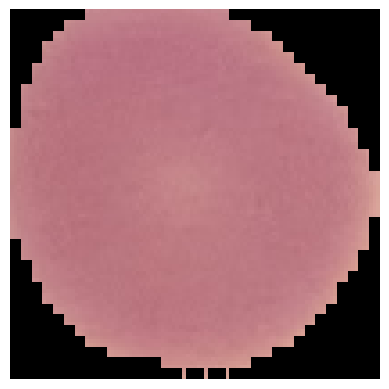

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

###Data Preparation

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size=len(dataset)

  train_dataset=dataset.take(int(TRAIN_RATIO*dataset_size))
  val_dataset=dataset.skip(int(TRAIN_RATIO*dataset_size))
  test_dataset=val_dataset.skip(int(VAL_RATIO*dataset_size))
  val_dataset=val_dataset.take(int(VAL_RATIO*dataset_size))

  return train_dataset, val_dataset, test_dataset

In [ ]:
dataset_try=tf.data.Dataset.range(10)
a = dataset_try.take(8)
b = dataset_try.skip(8)
c = b.skip(1)
b = b.take(1)

dataset_try = dataset_try.as_numpy_iterator()
print(list(a.as_numpy_iterator()))
print(list(b.as_numpy_iterator()))
print(list(c.as_numpy_iterator()))



[0, 1, 2, 3, 4, 5, 6, 7]
[8]
[9]


In [ ]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
#print(list(test_dataset.as_numpy_iterator()))

In [ ]:
print(list(test_dataset.take(1).as_numpy_iterator()))

###Data Visualization

In [ ]:
dataset_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

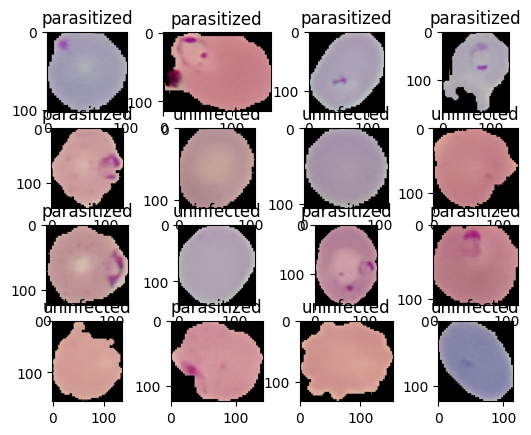

In [ ]:
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

###Data Preprocessing

**Data Augmentation**

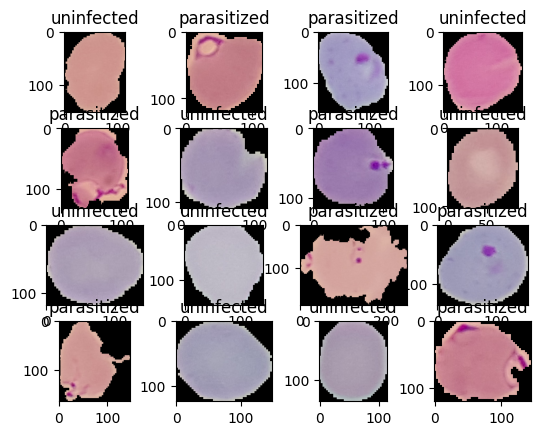

In [ ]:
# Test different data augmentation functions like contrast, brightness, rotate etc
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4, i+1)
  plt.imshow(tf.image.adjust_contrast(image, 1.))
  plt.title(dataset_info.features['label'].int2str(label))

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
@tf.function
def resizeAndRescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [ ]:
# resize with layers
resizeAndRescaleLayers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255),
])

def resizeAndRescaleLayer(image, label):
  return resizeAndRescaleLayers(image, training=True), label

In [ ]:
# augment with tf.image
@tf.function
def augment(image, label):
  image, label = resizeAndRescale(image, label)
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [ ]:
class rotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [ ]:
# augment with tf.keras.layers class
augment_layers = tf.keras.Sequential([
    rotNinety(),
    RandomFlip(mode='horizontal',),
])

def augment_layer(image, label):
  return augment_layers(resizeAndRescaleLayers(image), training=True), label

In [ ]:
#train_dataset=train_dataset.map(resizeAndRescale)
#val_dataset=val_dataset.map(resizeAndRescaleLayers)
test_dataset=test_dataset.map(resizeAndRescale)

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

###Mixup Augmentation

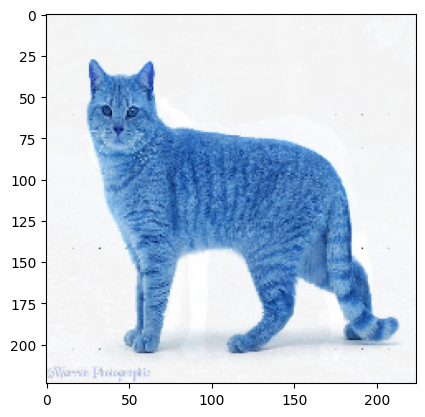

In [ ]:
# try with example
lamda = tfp.distributions.Beta(
  0.2,
  0.2
)

lamda = lamda.sample(1)[0]

image1 = cv2.resize(cv2.imread('cat.jpg'), (IM_SIZE, IM_SIZE))
image2 =  cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))
label1 = 0
label2 = 1

image = lamda * image1 + (1 - lamda)* image2
label = lamda * label1 + (1 - lamda)* label2

plt.imshow(image/255)

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size=4096, reshuffle_each_iteration=True).map(resizeAndRescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=4096, reshuffle_each_iteration=True).map(resizeAndRescale)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)

In [ ]:
def mixupAugmentation(train_dataset_1, train_dataset_2):
  lamda = tfp.distributions.Beta(0.2, 0.2)

  lamda = lamda.sample(1)[0]

  (image1, label1), (image2, label2) =  train_dataset_1, train_dataset_2

  image = lamda * image1 + (1 - lamda)* image2
  label = lamda * tf.cast(label1, dtype=tf.float32) + (1 - lamda)* tf.cast(label2, dtype=tf.float32)

  return image, label

###Cutmix Augmentation

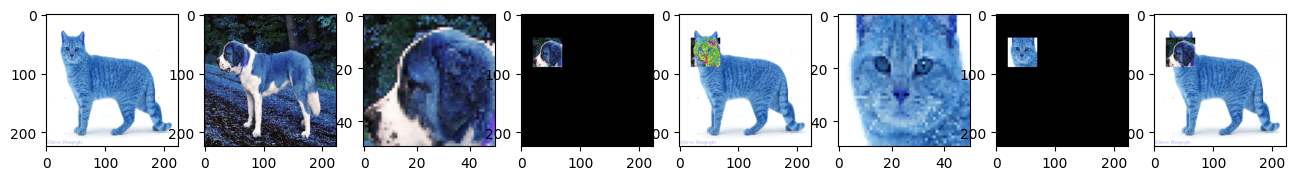

In [ ]:
#test cutmix
plt.figure(figsize=(16, 8))
image1 = cv2.resize(cv2.imread('cat.jpg'), (IM_SIZE, IM_SIZE))
plt.subplot(1,8,1)
plt.imshow(image1)

#plt.figure(figsize=(8, 6))
image2 = cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))
plt.subplot(1,8,2)
plt.imshow(image2)

plt.subplot(1,8,3)
image3 = tf.image.crop_to_bounding_box(image2, 40, 20, 50, 50)
plt.imshow(image3)

plt.subplot(1,8,4)
image4 = tf.image.pad_to_bounding_box(image3, 40, 20, IM_SIZE, IM_SIZE)
plt.imshow(image4)

plt.subplot(1,8,5)
image5 = image4 + image1
plt.imshow(image5)

plt.subplot(1,8,6)
image6 = tf.image.crop_to_bounding_box(image1, 40, 20, 50, 50)
plt.imshow(image6)

plt.subplot(1,8,7)
image7 = tf.image.pad_to_bounding_box(image6, 40, 20, IM_SIZE, IM_SIZE)
plt.imshow(image7)

plt.subplot(1,8,8)
image8 = image5 - image7
plt.imshow(image8)

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
  #print(r_x, r_y)

  r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
  r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h ==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmixAugmentation(train_dataset_1, train_dataset_2):
  (image1, label1), (image2, label2) =  train_dataset_1, train_dataset_2
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]
  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)
  crop_1 = tf.image.crop_to_bounding_box(image1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image1-pad_1+pad_2

  lamda = tf.cast(1 - ((r_w*r_h)/(IM_SIZE*IM_SIZE)), dtype=tf.float32)
  label = lamda*tf.cast(label1, dtype=tf.float32)  + (1 - lamda)*tf.cast(label2, dtype=tf.float32)
  return image, label

(103, 103, 3)


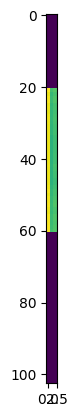

In [ ]:
orig_image, label = next(iter(train_dataset))
plt.imshow(orig_image[0])
print(orig_image.shape)

In [ ]:
BATCH_SIZE=32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    #.map(mixupAugmentation)
    .map(cutmixAugmentation)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

NameError: name 'mixed_dataset' is not defined

###Albumentations

In [ ]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
#!pip install -q -U albumentations
!pip uninstall albumentations
!pip install albumentations==1.4.14

In [ ]:
!pip uninstall albucore
!pip install albucore==0.0.15

In [ ]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = A.Compose([
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(), A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    # Set the shape of the augmented image to avoid shape issues in the pipeline
    aug_img.set_shape((224, 224, 3))
    return aug_img, label

###Data Loading

In [ ]:
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    #.map(mixupAugmentation)
    .map(process_data) #albumentation
    #.map(cutmixAugmentation)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(resizeAndRescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

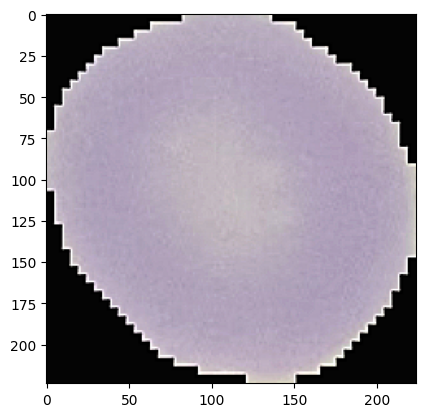

In [ ]:
#view albumented images
img, lbl = next(iter(train_dataset))
plt.imshow(img[0])

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

###Wandb dataset versioning

###Data loading

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

print(dataset)

In [ ]:
k = 0
for data in dataset[0]:

  with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
      np.savez(file, data)
  k += 1
  if(k%1000 == 0):
    print(k)

In [ ]:
k = 0
for data in dataset[0]:
    # Assuming `data` is a tuple (image_tensor, label_tensor)
    image_tensor, label_tensor = data  # Unpack the tuple
    image = image_tensor.numpy()  # Convert the image tensor to NumPy array
    label = label_tensor.numpy()  # Convert the label tensor to NumPy array

    file_path = os.path.join('dataset', f'malaria_dataset_{k}.npz')

    try:
        with open(file_path, mode='wb') as file:
            np.savez(file, image=image, label=label)
        k += 1
        if(k%1000 == 0):
          print(k)
    except Exception as e:
        print(f"Error saving file {file_path}: {e}")

In [ ]:
def load_original_data():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [ ]:
load_original_data()

###Data Preprocessing

In [ ]:
with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:
  artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/new_dataset:v0', type='raw_data')
  artifact_dir = artifact.download()

In [ ]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [ ]:
def preprocess_data():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset",
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",

    )

    artifact_directory = "artifacts/new_dataset:v0/"

    dataset_x = []
    dataset_y = []

    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)

    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [ ]:

def preprocess_data():
    with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:
        artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()

        preprocessed_data = wandb.Artifact(
            name="preprocessed_dataset",
            type="preprocessed_data",
            description="A Preprocessed version of the Malaria dataset",
        )

        artifact_directory = os.path.join("artifacts", "new_dataset:v0")

        dataset_x = []
        dataset_y = []

        for f in os.listdir(artifact_directory)[:1000]:
            try:
                with open(os.path.join(artifact_directory, f), 'rb') as file:
                    npz_array = np.load(file, allow_pickle=True)
                    print(npz_array.files)  # Check the keys of the arrays in the npz file

                    # Access using the correct keys
                    image = npz_array['image']  # Access the image using its key
                    label = npz_array['label']  # Access the label using its key

                    dataset_x.append(resize_rescale(image))
                    dataset_y.append(label)
            except Exception as e:
                print(f"Error processing file {f}: {e}")

        with preprocessed_data.new_file("prep_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=dataset_x, dataset_y=dataset_y)

        run.log_artifact(preprocessed_data)



In [ ]:
preprocess_data()

###Data Splitting

In [ ]:
run = wandb.init()
artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/preprocessed_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/preprocessed_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    artifact_file = "artifacts/preprocessed_dataset:v1/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
def split_data():
    with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:
        artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        train_data = wandb.Artifact(
            name="train_dataset",
            type="preprocessed_data",
            description="Training dataset",
        )
        val_data = wandb.Artifact(
            name="val_dataset",
            type="preprocessed_data",
            description="Validation dataset",
        )
        test_data = wandb.Artifact(
            name="test_dataset",
            type="preprocessed_data",
            description="Test dataset",
        )

        artifact_file = os.path.join(artifact_dir, 'prep_dataset.npz')  # Adjusted for correct path

        with open(artifact_file, 'rb') as file:
            npz_arr = np.load(file, allow_pickle=True)
            images, labels = npz_arr['dataset_x'], npz_arr['dataset_y']  # Access with correct keys

        train_split = 0.8
        val_split = 0.1
        test_split = 0.1

        data_len = len(images)

        train_arr = [images[:int(train_split * data_len)], labels[:int(train_split * data_len)]]
        val_arr = [images[int(train_split * data_len):int((train_split + val_split) * data_len)],
                    labels[int(train_split * data_len):int((train_split + val_split) * data_len)]]
        test_arr = [images[int((train_split + val_split) * data_len):],
                    labels[int((train_split + val_split) * data_len):]]

        with train_data.new_file("train_dataset.npz", mode="wb") as file:
            np.savez(file, images=train_arr[0], labels=train_arr[1])

        with val_data.new_file("val_dataset.npz", mode="wb") as file:
            np.savez(file, images=val_arr[0], labels=val_arr[1])

        with test_data.new_file("test_dataset.npz", mode="wb") as file:
            np.savez(file, images=test_arr[0], labels=test_arr[1])

        run.log_artifact(train_data)
        run.log_artifact(val_data)
        run.log_artifact(test_data)



In [ ]:
split_data()

###Augment data

In [ ]:
### tf.image augment
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
/contertifant/acts/train_dataset:v0/train_dataset.npz

In [ ]:
wandb.finish()

In [ ]:
def augment_data():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
def augment_data():
    with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:
        artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/train_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        augmented_data = wandb.Artifact(
            name="Augmented_dataset",
            type="preprocessed_data",
            description="An Augmented version of the Malaria train dataset",
        )

        artifact_file = os.path.join(artifact_dir, 'train_dataset.npz')  # Adjust for correct path

        dataset_x = []
        dataset_y = []

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)

            images = npz_array['images']  # Adjust to match your saved keys
            labels = npz_array['labels']  # Adjust to match your saved keys

            for im in images:
                dataset_x.append(augment(im))
            dataset_y = labels  # Store labels directly

        # Save the augmented dataset with meaningful keys
        with augmented_data.new_file("aug_dataset.npz", mode="wb") as file:
            np.savez(file, images=dataset_x, labels=dataset_y)  # Save with specific keys

        run.log_artifact(augmented_data)

In [ ]:
augment_data()

###Model Creation

###Wandb model versioning

###Untrained model versioning

In [ ]:
def log_model():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

###Trained model versioning

In [ ]:
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']
def train_and_log():
  with wandb.init(project="Malaria_Diagnosis", entity="PrakyathDl") as run:

    artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model",
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        images = npz_array['images']  # Adjust according to saved keys
        labels = npz_array['labels']  # Adjust according to saved keys

        # Optionally normalize the images if needed
        dataset_x = images  # Normalize if pixel values are [0, 255]
        dataset_y = labels


    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('PrakyathDl/Malaria_Diagnosis/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_d,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbMetricsLogger()],
    )

    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)

In [ ]:
train_and_log()

###Sequential API

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

###Functional API

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=3, strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2)
])
feature_extractor_seq_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1,padding='valid',activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_extractor_seq_model(func_input)
x = Flatten()(x)

x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name = "Lenet Model")
lenet_model.summary()

Model: "Lenet Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

###Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filterNo, kernelSize, stridesNo, padding, activation, poolSize):
    super(FeatureExtractor, self).__init__()
    self.Conv1 = Conv2D(filters=filterNo, kernel_size=kernelSize, strides=stridesNo,padding=padding,activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=poolSize, strides=2*stridesNo)
    self.Conv2 = Conv2D(filters=filterNo*2, kernel_size=kernelSize, strides=stridesNo,padding=padding,activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=poolSize, strides=2*stridesNo)

  def call(self, x, training):
    x = self.Conv1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.Conv2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_subclassed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.featureExtractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100,activation='relu')
    self.batch_3 = BatchNormalization()
    self.dense_2 = Dense(10,activation='relu')
    self.batch_4 = BatchNormalization()
    self.dense_3 = Dense(1,activation='sigmoid')

  def call(self, x, training=True):
    x = self.featureExtractor(x, training=training)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_3(x)
    x = self.dense_2(x)
    x = self.batch_4(x)
    x = self.dense_3(x)

    return x

lenet_subclassed = LenetModel()
lenet_subclassed(tf.zeros([1,224,224,3]))
lenet_subclassed.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_subclassed(func_input, training = True)
x = Flatten()(x)

x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name = "Lenet Model")
lenet_model.summary()

Model: "Lenet Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

###Custom Layers

In [ ]:
class CustomDense(Layer):
  def __init__(self, output_units, activation):
    super().__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output


In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6, kernel_size=3, strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    CustomDense(100, activation="relu"),
    BatchNormalization(),
    CustomDense(10,activation="relu"),
    BatchNormalization(),
    CustomDense(1,activation="sigmoid")
])
lenet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_dense (CustomDense)           │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_dense_1 (CustomDense)         │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_dense_2 (CustomDense)         │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
lenet_model=tf.keras.models.load_model("drive/MyDrive/TensorflowModels/lenetModel.hdf5")

###Error Sanctioning

In [ ]:
y_act = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
y_act = tf.convert_to_tensor(y_act, dtype=tf.float32)
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_act, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0863576>

###Custom Loss Class

In [ ]:
class customBceClass(Loss):
  def __init__(self, FACTOR):
    super().__init__()
    self.factor = FACTOR

  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * self.factor

###Custom loss method(with params)

In [ ]:
FACTOR = 1
def customBceWithParams(Factor):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)*Factor
  return loss

In [ ]:
def customBce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

###Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
    super(CustomAccuracy, self).__init__()
    self.factor = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')


  def update_state(self, y_true, y_pred, sample_weight = None):
    output = tf.keras.metrics.binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred) * self.factor
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(tf.shape(output)[0], dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

###Custom Metrics(with params)

In [ ]:
def customAccuracy(FACTOR):
  def binAccuracy(y_true, y_pred):
    return BinaryAccuracy(y_true, y_pred)* FACTOR
  return binAccuracy

###Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epochs_end(self, epoch, logs=met):
    print("\n For epoch number {} the model has loss of {} ".format(epoch+1, logs['loss']))
  def on_batch_end(self, batch, logs):
    print("\n For batch number {} the model has loss of {} ".format(batch+1, logs))

**Log Images Callback**

In [ ]:
def LogImagesCallback(Callback):
  def on_epochs_end(self, epoch, logs):
    labels = []
    inp = []
    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels ])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])
    threshold = 0.99 #0.5

    cm = confusion_matrix(labels, predicted > threshold)
    print(cm)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, foramt='png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

**CSV Callback**

In [ ]:
csv_callback = CSVLogger(
    'model_log.csv', append=True
)

**Early Stopping Callback**

In [ ]:
Early_Stopping_cb=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

**Learning Rate Sheduler**

In [ ]:
def scheduler(epoch, lr):
    if epoch <=1 :
        learningRate = lr
    else:
        learningRate = lr * tf.math.exp(-0.1)
        learningRate = learningRate.numpy()
    with train_writer.as_default():
      tf.summary.scalar('Learning Rate', data=learningRate, step=epoch)
    return learningRate

In [ ]:
LearningRateSchedulerCallback=LearningRateScheduler(
    schedule, verbose=1
)

**Model Checkpointing Callback**

In [ ]:
model_checkpoint_callback=ModelCheckpoint(
    'checkpoints/weights.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

**ReduceLearningRateOnPlateau**

In [ ]:
ReduceLROnPlateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)

###Tensorboard

In [ ]:
#!rm -rf 'drive/MyDrive/TensorflowModels/model_logs/'

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
print(LOG_DIR)

drive/MyDrive/TensorflowModels/model_logs/011024 - Oct101727810410


###Load Saved Model

In [ ]:
lenet_loaded_model=tf.keras.models.load_model("lenetModel.hdf5")

In [ ]:
lenet_loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)

###Model Training

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
#custom Wandb callback
class CustomWandbCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    wandb.log(logs)
  def on_train_end(self, logs=None):
    wandb.finish()

In [ ]:
LEARNING_RATE = CONFIGURATION['LEARNING_RATE']
lenet_model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=BinaryCrossentropy(), #customBceClass(FACTOR),
    metrics= metrics #[CustomAccuracy(),]
)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1 , callbacks=[WandbMetricsLogger()])

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 112s 162ms/step - accuracy: 0.7562 - auc: 0.8262 - fn: 1214.5594 - fp: 1073.2043 - loss: 0.5225 - precision: 0.7689 - recall: 0.7374 - tn: 4440.2886 - tp: 4327.8955 - val_accuracy: 0.9183 - val_auc: 0.9701 - val_fn: 92.0000 - val_fp: 133.0000 - val_loss: 0.2237 - val_precision: 0.9069 - val_recall: 0.9337 - val_tn: 1235.0000 - val_tp: 1295.0000
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 145ms/step - accuracy: 0.9211 - auc: 0.9661 - fn: 383.0130 - fp: 502.8768 - loss: 0.2232 - precision: 0.9131 - recall: 0.9315 - tn: 5018.6680 - tp: 5151.3896 - val_accuracy: 0.8642 - val_auc: 0.9616 - val_fn: 22.0000 - val_fp: 352.0000 - val_loss: 0.3926 - val_precision: 0.7956 - val_recall: 0.9842 - val_tn: 1011.0000 - val_tp: 1370.0000
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 146ms/step - accuracy: 0.9285 - auc: 0.9732 - fn: 333.7333 - fp: 457.7290 - loss: 0.1982 - precision: 0.9206 - recall: 0.9391 - tn: 5059.5361 - tp: 5204.9492 - val_accuracy: 0.9445 - 

In [ ]:
wandb.finish()

###Hyperparameter tuning (Wandb)

In [ ]:
sweep_config = {
  "name" : "Malaria-Diagnosis-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [ ]:
def train():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=2, callbacks = [WnndbMetricsLogger()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

###Custom Training Loops

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME + '/custom/train'
CUSTOM_VALIDATION_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME + '/custom/validation'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VALIDATION_DIR)

In [ ]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder: #This will record the gradient during the forward pass
    y_pred = lenet_model(x_batch, training=True)
    loss = customBce(y_batch, y_pred)

  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights) #This is equivalent to d(L)/d(theta)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights)) #This is equivalent to the formula to update weights based on gradient calculated above

  METRIC.update_state(y_batch, y_pred)
  return loss

In [ ]:
@tf.function
def validation_block(x_batch_val, y_batch_val):
  with tf.GradientTape() as recorder: #This will record the gradient during the forward pass
    y_pred_val = lenet_model(x_batch_val, training=False)
    val_loss = customBce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return val_loss

In [ ]:
for epoch in range(EPOCHS):
  print("Training starts for Epoch Number {}".format(epoch+1))
  for steps, (x_batch, y_batch) in enumerate(train_dataset):
    loss = training_block(x_batch, y_batch)

    #if (steps%300==0):
  print("Training loss: ", loss)
  print("Training Accuracy is:", METRIC.result())

  with custom_train_writer.as_default():
    tf.summary.scalar('Training Loss', data=loss, step=epoch)
  with custom_train_writer.as_default():
    tf.summary.scalar('Training Accuracy', data=METRIC.result(), step=epoch)

  METRIC.reset_state()

  for steps, (x_batch_val, y_batch_val) in enumerate(val_dataset):
    val_loss = validation_block(x_batch_val, y_batch_val)
  print("Validation Loss:", val_loss)
  print("Validation Accuracy is: ", METRIC_VAL.result())

  with custom_val_writer.as_default():
    tf.summary.scalar('Validation Loss', data=val_loss, step=epoch)
  with custom_val_writer.as_default():
    tf.summary.scalar('Validation Accuracy', data=METRIC_VAL.result(), step=epoch)

  METRIC_VAL.reset_state()

Training loss:  tf.Tensor(0.51061136, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.68857133, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.6501127, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.53209865, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.48295975, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.5396967, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.53970915, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.67088056, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.59531367, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.51473767, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.6290534, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.61507076, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.70186937, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.62767065, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.49749473, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.530292, shape=(), dtype=float3

KeyboardInterrupt: 

In [ ]:
def customTrain(model, loss_function, train_dataset, val_dataset, OPTIMIZER, METRIC, METRIC_VAL, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for Epoch Number {}".format(epoch+1))
    for steps, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)

      #if (steps%300==0):
    print("Training loss: ", loss)
    print("Training Accuracy is:", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data=loss, step=epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data=METRIC.result(), step=epoch)
    METRIC.reset_state()

    for steps, (x_batch_val, y_batch_val) in enumerate(val_dataset):
      val_loss = validation_block(x_batch_val, y_batch_val)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data=val_loss, step=epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data=METRIC_VAL.result(), step=epoch)
    METRIC_VAL.reset_state()
  print("Training Complete!!!")

In [ ]:
customTrain(lenet_model, customBce, train_dataset, val_dataset, OPTIMIZER, METRIC, METRIC_VAL, EPOCHS)

Training starts for Epoch Number 1
Training loss:  tf.Tensor(0.60638934, shape=(), dtype=float32)
Training Accuracy is: tf.Tensor(0.66982675, shape=(), dtype=float32)
Training starts for Epoch Number 2
Training loss:  tf.Tensor(0.574941, shape=(), dtype=float32)
Training Accuracy is: tf.Tensor(0.6999002, shape=(), dtype=float32)
Training starts for Epoch Number 3
Training loss:  tf.Tensor(0.48363116, shape=(), dtype=float32)
Training Accuracy is: tf.Tensor(0.7128731, shape=(), dtype=float32)
Training Complete!!!


###Visualization

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir="drive/MyDrive/TensorflowModels/model_logs/"

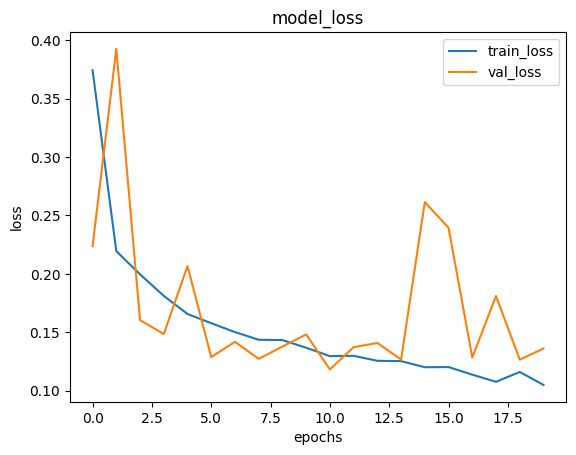

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

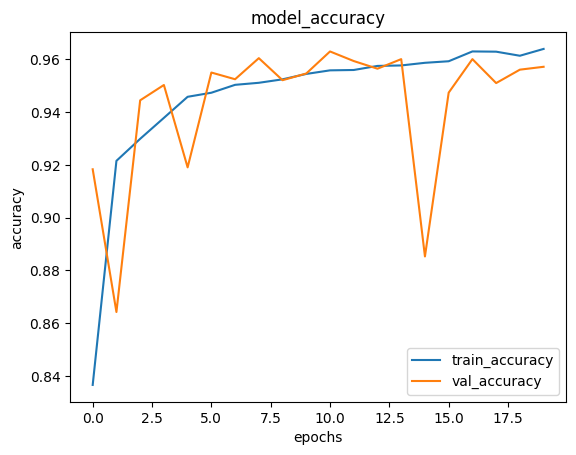

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

###Model Evaluation and Testing

In [ ]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
def parasiticOrUnparasitic(x):
  if (x<0.5):
    return str('p')
  else:
    return str('u')

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9458 - auc: 0.9768 - fn: 34.3035 - fp: 41.1012 - loss: 0.5616 - precision: 0.9422 - recall: 0.9484 - tn: 650.9003 - tp: 653.1947


[1.107161045074463,
 1287.0,
 86.0,
 1311.0,
 73.0,
 0.9423286318778992,
 0.9373634457588196,
 0.9463235139846802,
 0.9758219718933105]

###Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(labels)

[array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), arr

In [ ]:
print(inp[0].shape)
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(1, 224, 224, 3)
(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [ ]:
labels = np.array([i[0] for i in labels ])
print(labels)

[0 1 0 ... 1 0 1]


In [ ]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
[0.4263533  0.6141986  0.00872961 ... 0.97893757 0.00302535 0.79487777]


[[1320   73]
 [  89 1275]]


Text(0.5, 58.7222222222222, 'Predicted')

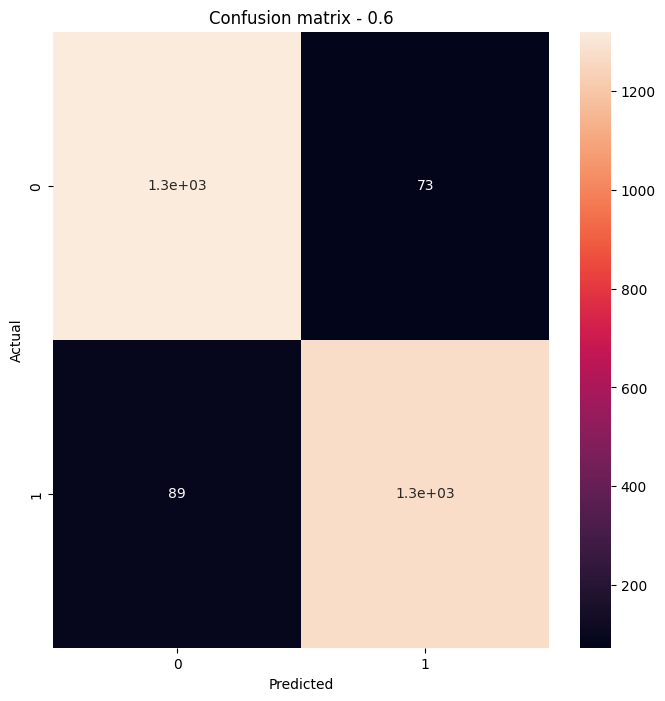

In [ ]:
threshold = 0.6 #0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
fn: 55.5069 - fp: 85.2977
tn: 599.5762 - tp: 639.1189

###ROC Plots

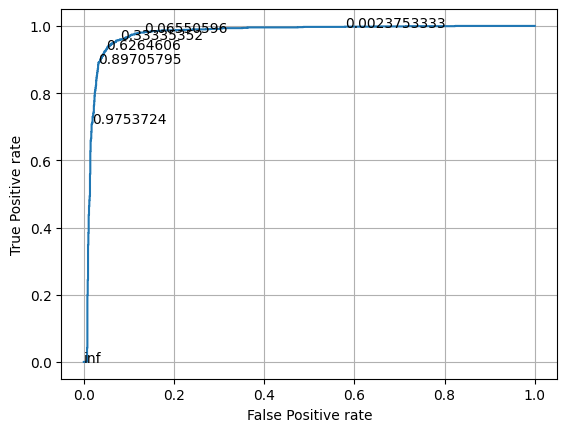

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
#print(len(fp), len(tp), len(thresholds))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 40

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [ ]:
parasiticOrUnparasitic(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


'u'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


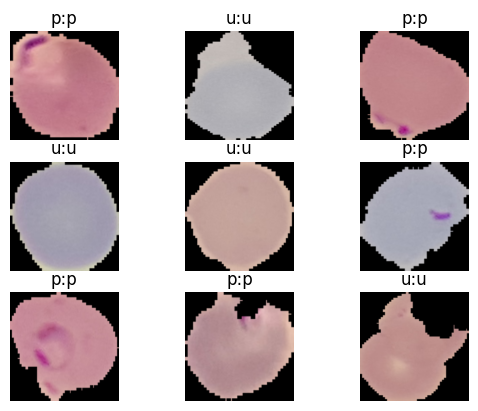

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasiticOrUnparasitic(label.numpy()[0])) + ":" + str(parasiticOrUnparasitic(lenet_model.predict(image)[0][0])))
  plt.axis('off')

###Save Model

In [ ]:
lenet_model.save("drive/MyDrive/TensorflowModels/lenetModel_augment.hdf5")

In [ ]:
lenet_model.save("drive/MyDrive/TensorflowModels/lenetModel_96Accuracy.keras")

### Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


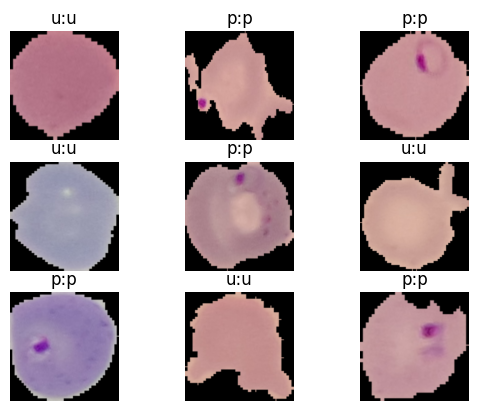

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasiticOrUnparasitic(label.numpy()[0])) + ":" + str(parasiticOrUnparasitic(lenet_loaded_model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
lenet_loaded_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9188 - loss: 0.6127


[0.6883719563484192, 0.918026864528656]

In [ ]:
lenet_model.save_weights("weights/lenet_weights.weights.h5")